<a href="https://colab.research.google.com/github/khanabdulmajid/tensorflow_deep_learning/blob/main/07_Project_1_Food_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1. Food Vision

In [1]:
!nvidia-smi -L

# Install tf-nightly (required until 2.13.0+ is the default in Google Colab)
!pip install -U -q tf-nightly

# Check TensorFlow version (should be minimum 2.4.0+ but 2.13.0+ is better)
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

# Add timestamp
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

GPU 0: Tesla T4 (UUID: GPU-f6f8e380-0b34-3181-3137-b437dadbee8a)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.9/492.9 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.9/440.9 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 45.7 MB/s eta 0:00:00
TensorFlow version: 2.15.0-dev20230914
Notebook last run (end-to-end): 2023-09-14 11:26:31.335817


In [2]:
#getting helper functions
!wget https://raw.githubusercontent.com/khanabdulmajid/tensorflow_deep_learning/main/helper_functions.py

--2023-09-14 11:26:31--  https://raw.githubusercontent.com/khanabdulmajid/tensorflow_deep_learning/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-09-14 11:26:31 (96.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, plot_loss_curves

In [4]:
# download some data from tensorflow dataset

In [5]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

print(tf.__version__)
datasets_list=tfds.list_builders()
print("food101" in datasets_list)

2.15.0-dev20230914
True


In [ ]:
(train_data,test_data), ds_info=tfds.load("food101",
                                          split=["train","validation"],
                                          shuffle_files=True,
                                          as_supervised=True, #data is returned in tuple format (data,label)
                                          with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

#Exploring data form tfds

In [ ]:
 ds_info.features

In [ ]:
#get class names
class_names=ds_info.features["label"].names
class_names

## exporing food101 dataset from tf
need to find
* classnames
* shape of our inputdata (image tensors)
* their data type
* what their labels look like (one-hot encode or lale encoded)
* do the labels match up with the class names

In [ ]:
#take one sample of train data
train_one_sample=train_data.take(1)

In [ ]:
for image, label in train_one_sample:
  print(f"""
  image_shape: {image.shape}
  image_datatype:{image.dtype}
  taget_class:{label},
  class_name:{class_names[label]}
        """

  )

conclusion
* labels are not one-hot encoded


In [ ]:
#min and max values in the image
tf.reduce_min(image), tf.reduce_max(image)

In [ ]:
# plot the image
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

In [ ]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
    """
    Converts image datatype from 'uint8' -> 'float32' and reshapes image to
    [img_shape, img_shape, color_channels]
    """
    image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
    return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [ ]:
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

# Batch and prepare datasets
fetch the data from tfds through a pipeline

In [ ]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_data,test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [ ]:
# creating a callback
model_checkpoint_dir="model_checkpoint/cp.ckpt"
model_checkpoint=tf.keras.callbacks.ModelCheckpoint(filepath=model_checkpoint_dir,
                                                    monitor="val_acc",
                                                    save_best_only=True,
                                                    save_weights_only=True,
                                                    verbose=0
                                                    )

In [ ]:
#mixed precisiontraiing

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16") # set global data plolicy to mixed precision


Setup mixed precision training

We touched on mixed precision training above.

However, we didn't quite explain it.

Normally, tensors in TensorFlow default to the float32 datatype (unless otherwise specified).

In computer science, float32 is also known as single-precision floating-point format. The 32 means it usually occupies 32 bits in computer memory.

Your GPU has a limited memory, therefore it can only handle a number of float32 tensors at the same time.

This is where mixed precision training comes in.

Mixed precision training involves using a mix of float16 and float32 tensors to make better use of your GPU's memory.

Can you guess what float16 means?

Well, if you thought since float32 meant single-precision floating-point, you might've guessed float16 means half-precision floating-point format. And if you did, you're right! And if not, no trouble, now you know.

For tensors in float16 format, each element occupies 16 bits in computer memory.

So, where does this leave us?

As mentioned before, when using mixed precision training, your model will make use of float32 and float16 data types to use less memory where possible and in turn run faster (using less memory per tensor means more tensors can be computed on simultaneously).

As a result, using mixed precision training can improve your performance on modern GPUs (those with a compute capability score of 7.0+) by up to 3x.

For a more detailed explanation, I encourage you to read through the TensorFlow mixed precision guide (I'd highly recommend at least checking out the summary).

Because mixed precision training uses a combination of float32 and float16 data types, you may see up to a 3x speedup on modern GPUs.

    🔑 Note: If your GPU doesn't have a score of over 7.0+ (e.g. P100 in Google Colab), mixed precision won't work (see: "Supported Hardware" in the mixed precision guide for more).

    📖 Resource: If you'd like to learn more about precision in computer science (the detail to which a numerical quantity is expressed by a computer), see the Wikipedia page (and accompanying resources).

Okay, enough talk, let's see how we can turn on mixed precision training in TensorFlow.

The beautiful thing is, the tensorflow.keras.mixed_precision API has made it very easy for us to get started.

First, we'll import the API and then use the set_global_policy() method to set the dtype policy to "mixed_float16".


In [ ]:
mixed_precision.global_policy()

In [ ]:
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False



In [ ]:
for layer in base_model.layers:
  print(layer.name,layer.trainable,layer.dtype,layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
rescaling_1 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <

In [ ]:
input_shape=(224,224,3)
inputs=tf.keras.layers.Input(shape=input_shape,name="input_layer")
x=base_model(inputs,training=False)
x=tf.keras.layers.GlobalAveragePooling2D(name="GAP2d")(x)
x=tf.keras.layers.Dense(len(class_names))(x)
outputs=tf.keras.layers.Activation(activation="softmax",dtype=tf.float32,name="softmaxfloat_32")(x)
# make sure our outputs are in dtype float32

model_1=tf.keras.Model(inputs,outputs)
model_1.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
history_101=model_1.fit(train_data,
                        epochs=8,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=int(0.15*(len(test_data))),
                        callbacks=[create_tensorboard_callback("training_logs","efficientnetb0"),
                                   model_checkpoint]
                        )

Saving TensorBoard log files to: training_logs/efficientnetb0/20230914-082829
Epoch 1/8
2368/2368 [==============================] - ETA: 0s - loss: 1.7201 - accuracy: 0.5815

2368/2368 [==============================] - 211s 78ms/step - loss: 1.7201 - accuracy: 0.5815 - val_loss: 1.1204 - val_accuracy: 0.6997
Epoch 2/8
2368/2368 [==============================] - ETA: 0s - loss: 1.1997 - accuracy: 0.6891

2368/2368 [==============================] - 181s 75ms/step - loss: 1.1997 - accuracy: 0.6891 - val_loss: 1.0226 - val_accuracy: 0.7209
Epoch 3/8
2367/2368 [============================>.] - ETA: 0s - loss: 1.0532 - accuracy: 0.7254

2368/2368 [==============================] - 189s 79ms/step - loss: 1.0531 - accuracy: 0.7254 - val_loss: 0.9839 - val_accuracy: 0.7291
Epoch 4/8
2368/2368 [==============================] - ETA: 0s - loss: 0.9589 - accuracy: 0.7483

2368/2368 [==============================] - 180s 75ms/step - loss: 0.9589 - accuracy: 0.7483 - val_loss: 0.9783 - val_accuracy: 0.7325
Epoch 5/8
2367/2368 [============================>.] - ETA: 0s - loss: 0.8883 - accuracy: 0.7659

2368/2368 [==============================] - 181s 75ms/step - loss: 0.8883 - accuracy: 0.7659 - val_loss: 0.9645 - val_accuracy: 0.7378
Epoch 6/8
2368/2368 [==============================] - ETA: 0s - loss: 0.8331 - accuracy: 0.7810

2368/2368 [==============================] - 179s 75ms/step - loss: 0.8331 - accuracy: 0.7810 - val_loss: 0.9720 - val_accuracy: 0.7331
Epoch 7/8
2368/2368 [==============================] - ETA: 0s - loss: 0.7870 - accuracy: 0.7912

2368/2368 [==============================] - 179s 75ms/step - loss: 0.7870 - accuracy: 0.7912 - val_loss: 0.9662 - val_accuracy: 0.7346
Epoch 8/8
2368/2368 [==============================] - ETA: 0s - loss: 0.7467 - accuracy: 0.8026

2368/2368 [==============================] - 199s 83ms/step - loss: 0.7467 - accuracy: 0.8026 - val_loss: 0.9752 - val_accuracy: 0.7272


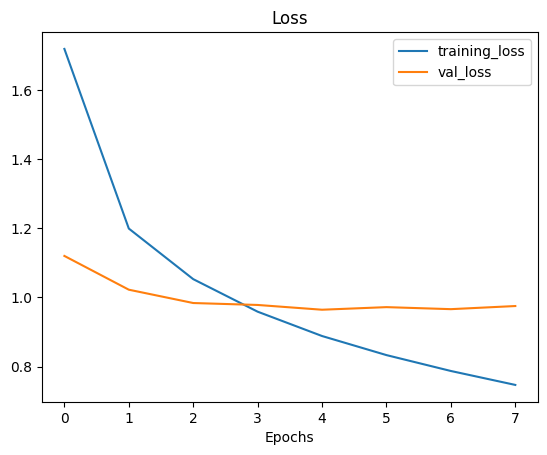

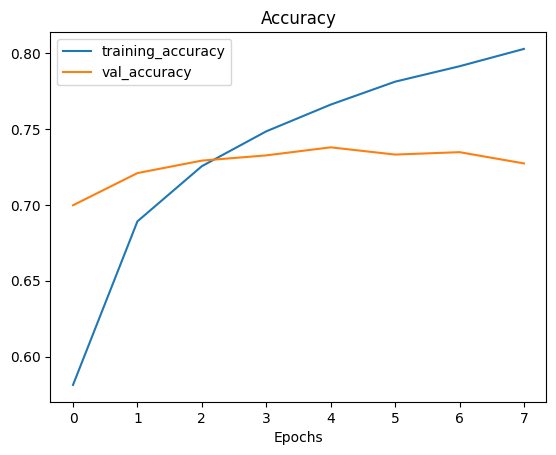

In [ ]:
plot_loss_curves(history_101)

#Fine Tuning

In [ ]:
base_model.trainable=True
for layer in base_model.layers[:-10]:
  layer.trainable=False

model_1.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

history_102=model_1.fit(train_data,
                        epochs=10,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=int(0.15*(len(test_data))),
                        callbacks=[create_tensorboard_callback("training_logs_finetuning","efficientnetb0"),
                                   model_checkpoint]
                        )


Saving TensorBoard log files to: training_logs_finetuning/efficientnetb0/20230914-085558
Epoch 1/10
2367/2368 [============================>.] - ETA: 0s - loss: 0.6542 - accuracy: 0.8243

2368/2368 [==============================] - 198s 78ms/step - loss: 0.6543 - accuracy: 0.8243 - val_loss: 0.9582 - val_accuracy: 0.7418
Epoch 2/10
2368/2368 [==============================] - ETA: 0s - loss: 0.5244 - accuracy: 0.8608

2368/2368 [==============================] - 181s 76ms/step - loss: 0.5244 - accuracy: 0.8608 - val_loss: 0.9815 - val_accuracy: 0.7426
Epoch 3/10
2367/2368 [============================>.] - ETA: 0s - loss: 0.4291 - accuracy: 0.8884

2368/2368 [==============================] - 175s 73ms/step - loss: 0.4291 - accuracy: 0.8884 - val_loss: 1.0132 - val_accuracy: 0.7434
Epoch 4/10
2367/2368 [============================>.] - ETA: 0s - loss: 0.3506 - accuracy: 0.9106

2368/2368 [==============================] - 177s 74ms/step - loss: 0.3506 - accuracy: 0.9106 - val_loss: 1.0429 - val_accuracy: 0.7474
Epoch 5/10
2367/2368 [============================>.] - ETA: 0s - loss: 0.2829 - accuracy: 0.9310

2368/2368 [==============================] - 182s 76ms/step - loss: 0.2829 - accuracy: 0.9310 - val_loss: 1.0703 - val_accuracy: 0.7463
Epoch 6/10
2367/2368 [============================>.] - ETA: 0s - loss: 0.2256 - accuracy: 0.9471

2368/2368 [==============================] - 179s 74ms/step - loss: 0.2256 - accuracy: 0.9471 - val_loss: 1.1312 - val_accuracy: 0.7421
Epoch 7/10
2368/2368 [==============================] - ETA: 0s - loss: 0.1761 - accuracy: 0.9624

2368/2368 [==============================] - 181s 76ms/step - loss: 0.1761 - accuracy: 0.9624 - val_loss: 1.1509 - val_accuracy: 0.7471
Epoch 8/10
2368/2368 [==============================] - ETA: 0s - loss: 0.1369 - accuracy: 0.9729

2368/2368 [==============================] - 180s 75ms/step - loss: 0.1369 - accuracy: 0.9729 - val_loss: 1.1775 - val_accuracy: 0.7426
Epoch 9/10
2368/2368 [==============================] - ETA: 0s - loss: 0.1039 - accuracy: 0.9825

2368/2368 [==============================] - 178s 74ms/step - loss: 0.1039 - accuracy: 0.9825 - val_loss: 1.2397 - val_accuracy: 0.7434
Epoch 10/10
2368/2368 [==============================] - ETA: 0s - loss: 0.0790 - accuracy: 0.9885

2368/2368 [==============================] - 178s 74ms/step - loss: 0.0790 - accuracy: 0.9885 - val_loss: 1.2516 - val_accuracy: 0.7407


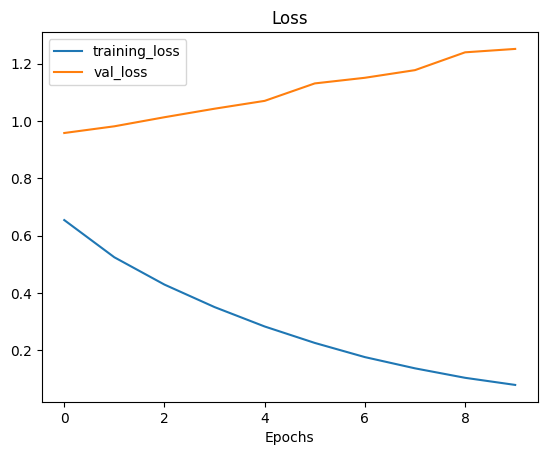

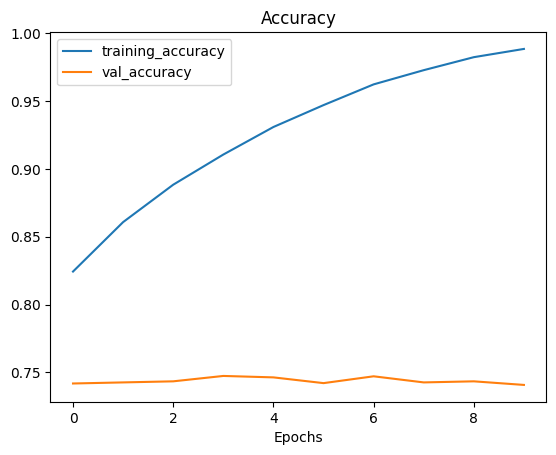

In [ ]:
plot_loss_curves(history_102)

In [ ]:
base_model.trainable=True
for layer in base_model.layers[:-20]:
  layer.trainable=False

model_1.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              metrics=["accuracy"])

history_103=model_1.fit(train_data,
                        epochs=20,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=int(0.15*(len(test_data))),
                        callbacks=[create_tensorboard_callback("training_logs_finetuning_2","efficientnetb0"),
                                   model_checkpoint],
                        initial_epoch=history_102.epoch[-1]
                        )


Saving TensorBoard log files to: training_logs_finetuning_2/efficientnetb0/20230914-094417
Epoch 10/20
2367/2368 [============================>.] - ETA: 0s - loss: 0.0243 - accuracy: 0.9988

2368/2368 [==============================] - 206s 81ms/step - loss: 0.0243 - accuracy: 0.9988 - val_loss: 1.3878 - val_accuracy: 0.7519
Epoch 11/20
2368/2368 [==============================] - ETA: 0s - loss: 0.0183 - accuracy: 0.9994

2368/2368 [==============================] - 199s 82ms/step - loss: 0.0183 - accuracy: 0.9994 - val_loss: 1.4608 - val_accuracy: 0.7489
Epoch 12/20
2367/2368 [============================>.] - ETA: 0s - loss: 0.0141 - accuracy: 0.9997

2368/2368 [==============================] - 196s 82ms/step - loss: 0.0141 - accuracy: 0.9997 - val_loss: 1.5100 - val_accuracy: 0.7526
Epoch 13/20
2368/2368 [==============================] - ETA: 0s - loss: 0.0111 - accuracy: 0.9999

2368/2368 [==============================] - 193s 80ms/step - loss: 0.0111 - accuracy: 0.9999 - val_loss: 1.5495 - val_accuracy: 0.7513
Epoch 14/20
2368/2368 [==============================] - ETA: 0s - loss: 0.0088 - accuracy: 0.9999

2368/2368 [==============================] - 191s 79ms/step - loss: 0.0088 - accuracy: 0.9999 - val_loss: 1.6001 - val_accuracy: 0.7495
Epoch 15/20
2368/2368 [==============================] - ETA: 0s - loss: 0.0071 - accuracy: 0.9999

2368/2368 [==============================] - 191s 79ms/step - loss: 0.0071 - accuracy: 0.9999 - val_loss: 1.6492 - val_accuracy: 0.7474
Epoch 16/20
2368/2368 [==============================] - ETA: 0s - loss: 0.0058 - accuracy: 0.9999

2368/2368 [==============================] - 192s 79ms/step - loss: 0.0058 - accuracy: 0.9999 - val_loss: 1.6799 - val_accuracy: 0.7481
Epoch 17/20
2368/2368 [==============================] - ETA: 0s - loss: 0.0046 - accuracy: 0.9999

2368/2368 [==============================] - 187s 78ms/step - loss: 0.0046 - accuracy: 0.9999 - val_loss: 1.7257 - val_accuracy: 0.7500
Epoch 18/20
2368/2368 [==============================] - ETA: 0s - loss: 0.0039 - accuracy: 0.9999

2368/2368 [==============================] - 200s 83ms/step - loss: 0.0039 - accuracy: 0.9999 - val_loss: 1.7608 - val_accuracy: 0.7516
Epoch 19/20
2367/2368 [============================>.] - ETA: 0s - loss: 0.0032 - accuracy: 0.9999

2368/2368 [==============================] - 191s 79ms/step - loss: 0.0032 - accuracy: 0.9999 - val_loss: 1.8286 - val_accuracy: 0.7476
Epoch 20/20
2367/2368 [============================>.] - ETA: 0s - loss: 0.0027 - accuracy: 0.9999

2368/2368 [==============================] - 190s 79ms/step - loss: 0.0027 - accuracy: 0.9999 - val_loss: 1.8628 - val_accuracy: 0.7492


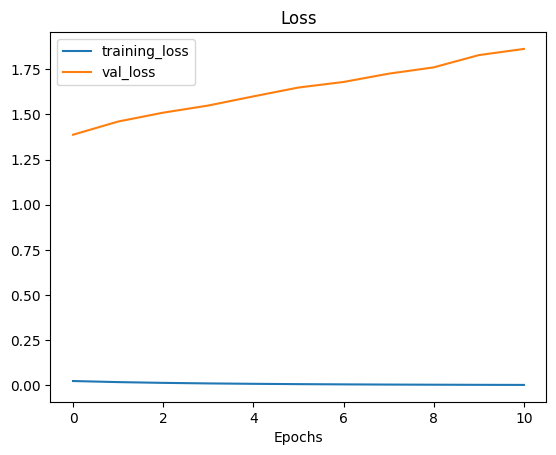

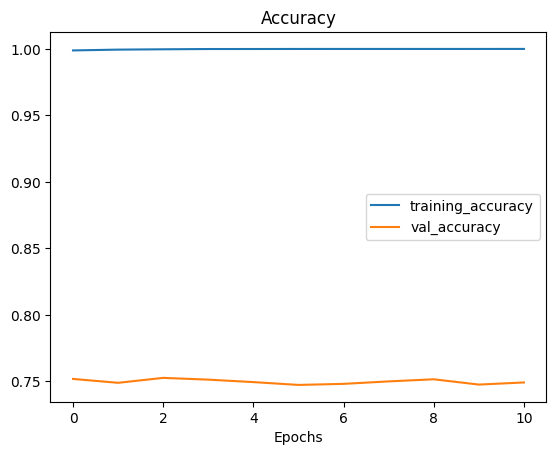

In [ ]:
plot_loss_curves(history_103)

In [ ]:
IMG_SIZE=224
early_stopping_callback=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", start_from_epoch=3)
data_augmentation=tf.keras.Sequential([
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),

])

In [ ]:
input_shape=(224,224,3)
inputs=tf.keras.layers.Input(shape=input_shape,name="input_layer")
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False
# for layer in base_model.layers[:10]:
#   layer.trainable=True

x=data_augmentation(inputs)
x=base_model(x,training=False)
x=tf.keras.layers.GlobalAveragePooling2D()(x)
x=tf.keras.layers.Dense(len(class_names)) (x)
outputs=tf.keras.layers.Activation(activation="softmax",dtype=tf.float32)(x)

model_data_aug=tf.keras.Model(inputs,outputs)
model_data_aug=tf.keras.Model(inputs,outputs)

model_data_aug.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_data_aug_model=model_data_aug.fit(
    train_data,
    epochs=5,
    validation_data=test_data,
    validation_steps=0.15*len(test_data),
    callbacks=[create_tensorboard_callback("experiment_1","efficientnetB0"),
               early_stopping_callback,model_checkpoint]
)


